# Build QAOA ansätze with `qiskit` and `qopt-best-practices`

In [1]:
# Uncomment and run this cell to install requirements for the notebook

# !pip install qopt-best-practices@git+https://github.com/qiskit-community/qopt-best-practices@1b92b695848ea0ecedbbc3ddb98769137e91e7d9
# !pip install qiskit-addon-opt-mapper==0.1.0
# !pip install matplotlib
# !pip install pylatexenc
# !pip install sympy

This notebook contains practical examples of how to construct different QAOA ansatz flavors.

<img src="images/ansatz.png" width="1200">


For more in-depth tutorials, check out the qopt-best-practices how-to section or the MOO challenge on Day 2 of the practitioners forum.

**Note**: cells marked as "SETUP" are not shown in the accompanying presentation

## 1. Standard QAOA Example

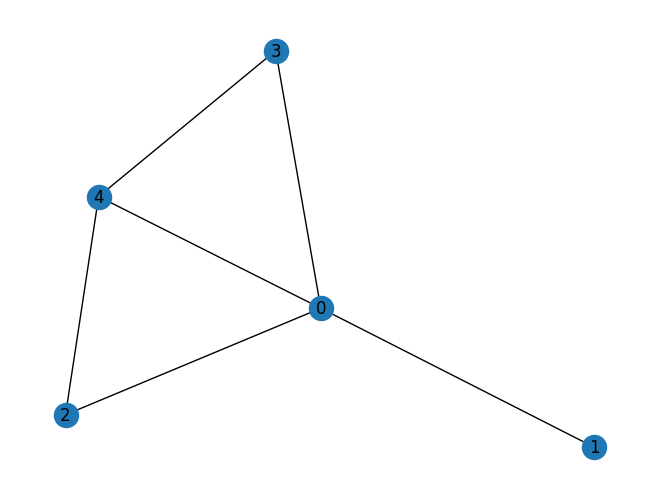

In [2]:
# SETUP: build graph

from networkx import barabasi_albert_graph, draw

graph = barabasi_albert_graph(n=5, m=3, seed=42)
draw(graph, with_labels=True)

In [3]:
from qopt_best_practices.utils import build_max_cut_paulis
from qiskit.quantum_info import SparsePauliOp

local_correlators = build_max_cut_paulis(graph)
cost_operator = SparsePauliOp.from_list(local_correlators)
print(cost_operator)

SparsePauliOp(['IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ', 'ZIZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [4]:
from qiskit.circuit.library import qaoa_ansatz

ansatz = qaoa_ansatz(cost_operator, reps=2)

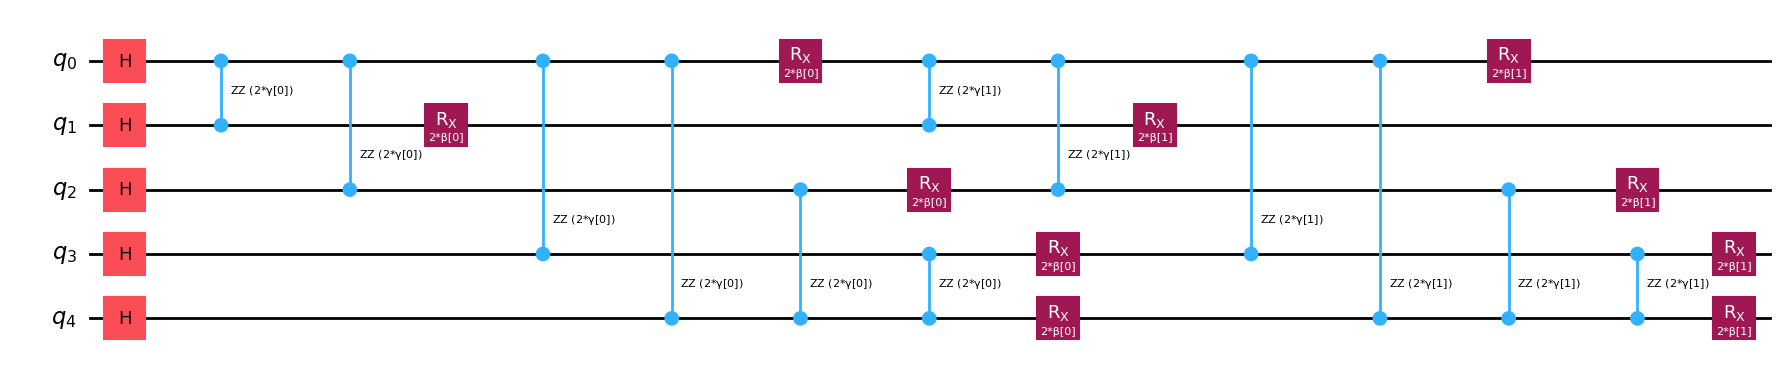

In [5]:
ansatz.draw("mpl", fold=-1)

## 2. Annotated standard QAOA Example

In [6]:
from qopt_best_practices.circuit_library import annotated_qaoa_ansatz

ansatz = annotated_qaoa_ansatz(cost_operator, reps=2)

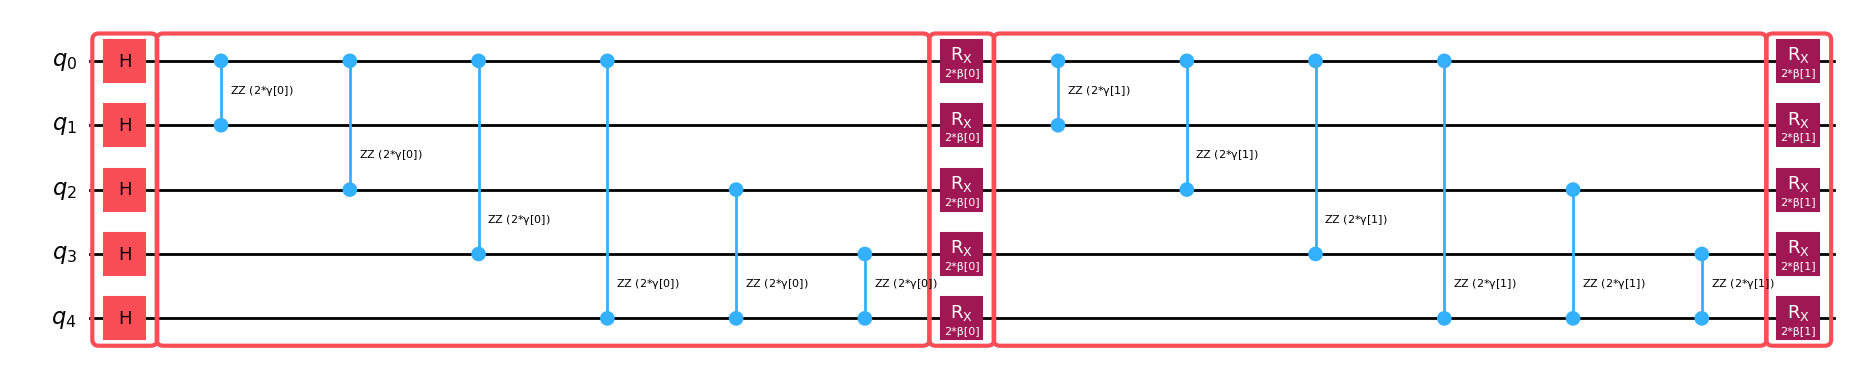

In [7]:
ansatz.draw("mpl", fold=-1)

## 3. Warm-start QAOA Example

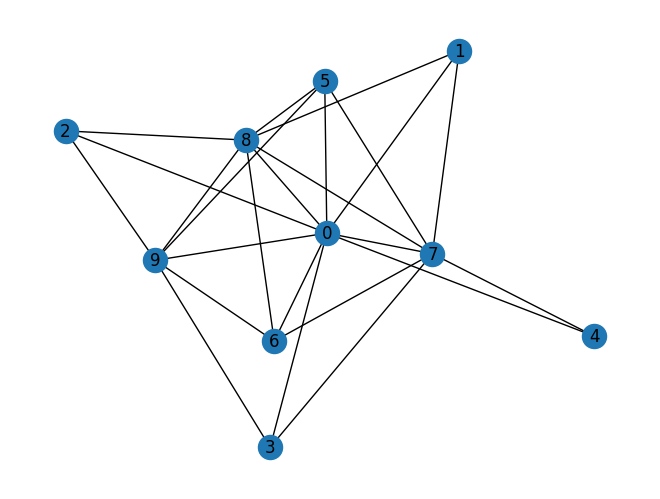

In [8]:
# SETUP: build graph

from networkx import barabasi_albert_graph, draw

graph = barabasi_albert_graph(n=10, m=6, seed=42)
draw(graph, with_labels=True)

In [9]:
# SETUP: get cost operator

from qopt_best_practices.utils import build_max_cut_paulis
from qiskit.quantum_info import SparsePauliOp

local_correlators = build_max_cut_paulis(graph)
cost_operator = SparsePauliOp.from_list(local_correlators)
print(cost_operator)

SparsePauliOp(['IIIIIIIIZZ', 'IIIIIIIZIZ', 'IIIIIIZIIZ', 'IIIIIZIIIZ', 'IIIIZIIIIZ', 'IIIZIIIIIZ', 'IIZIIIIIIZ', 'IZIIIIIIIZ', 'ZIIIIIIIIZ', 'IIZIIIIIZI', 'IZIIIIIIZI', 'IZIIIIIZII', 'ZIIIIIIZII', 'IIZIIIZIII', 'ZIIIIIZIII', 'IIZIIZIIII', 'IIZIZIIIII', 'IZIIZIIIII', 'ZIIIZIIIII', 'IIZZIIIIII', 'IZIZIIIIII', 'ZIIZIIIIII', 'IZZIIIIIII', 'ZZIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [10]:
# SETUP: define function to build mixer

from qiskit.quantum_info import SparsePauliOp
import numpy as np


def ws_mixer_sparse_pauli(theta_list):
    """
    Constructs the WS-QAOA mixer Hamiltonian as a SparsePauliOp.

    Args:
        theta_list (list of float): List of θ_i values for each qubit.

    Returns:
        SparsePauliOp: The mixer Hamiltonian.
    """
    n = len(theta_list)
    paulis = []
    coeffs = []

    for i, theta_i in enumerate(theta_list):
        sin_theta = -np.sin(theta_i)
        cos_theta = -np.cos(theta_i)

        # X_i term
        x_str = ["I"] * n
        x_str[i] = "X"
        paulis.append("".join(x_str))
        coeffs.append(sin_theta)

        # Z_i term
        z_str = ["I"] * n
        z_str[i] = "Z"
        paulis.append("".join(z_str))
        coeffs.append(cos_theta)

    return SparsePauliOp(paulis, coeffs)

In [11]:
from qiskit import QuantumCircuit

theta_list = [0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5]

init_state = QuantumCircuit(cost_operator.num_qubits)
for i, theta in enumerate(theta_list):
    init_state.ry(theta, i)

mixer_hamiltonian = ws_mixer_sparse_pauli(theta_list)

ansatz = annotated_qaoa_ansatz(
    cost_operator,
    initial_state=init_state,
    mixer_operator=mixer_hamiltonian,
    reps=2,
)

SparsePauliOp(['XIIIIIIIII', 'ZIIIIIIIII', 'IXIIIIIIII', 'IZIIIIIIII', 'IIXIIIIIII', 'IIZIIIIIII', 'IIIXIIIIII', 'IIIZIIIIII', 'IIIIXIIIII', 'IIIIZIIIII', 'IIIIIXIIII', 'IIIIIZIIII', 'IIIIIIXIII', 'IIIIIIZIII', 'IIIIIIIXII', 'IIIIIIIZII', 'IIIIIIIIXI', 'IIIIIIIIZI', 'IIIIIIIIIX', 'IIIIIIIIIZ'],
              coeffs=[-0.09983342+0.j, -0.99500417+0.j, -0.09983342+0.j, -0.99500417+0.j,
 -0.19866933+0.j, -0.98006658+0.j, -0.19866933+0.j, -0.98006658+0.j,
 -0.29552021+0.j, -0.95533649+0.j, -0.29552021+0.j, -0.95533649+0.j,
 -0.38941834+0.j, -0.92106099+0.j, -0.38941834+0.j, -0.92106099+0.j,
 -0.47942554+0.j, -0.87758256+0.j, -0.47942554+0.j, -0.87758256+0.j])


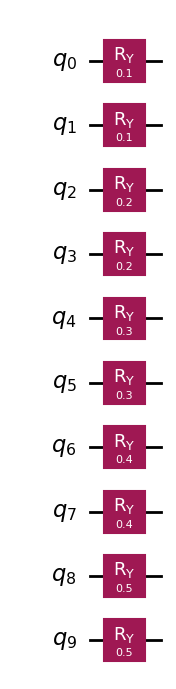

In [12]:
print(mixer_hamiltonian)
init_state.draw("mpl")

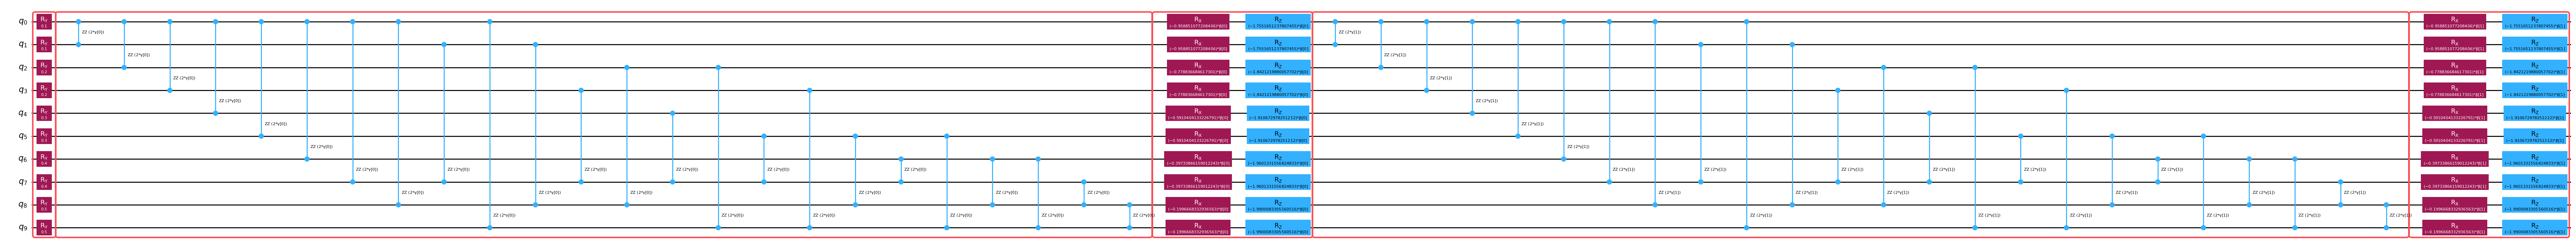

In [13]:
ansatz.draw("mpl", fold=-1)

## 4. MOO QAOA Example

In [14]:
# SETUP: load problem graphs

from qmoo_files import load_problem

moo_graphs, qaoa_params, upper_bound, lower_bound = load_problem(
    "./data/3_regular_static_12q/"
)
n_obj = len(moo_graphs)

loading ./data/3_regular_static_12q/problem_graph_*.json


/Users/ept/qiskit_workspace/qdc_opt_seminar/.venv_pf/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


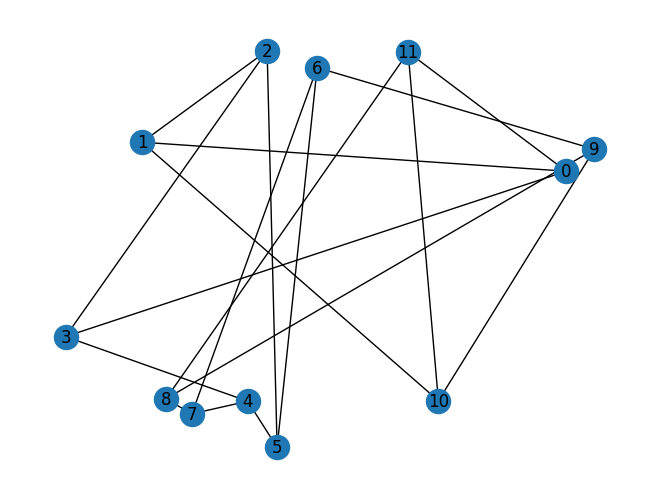

In [15]:
# SETUP: draw graph 0

draw(moo_graphs[0], with_labels=True)

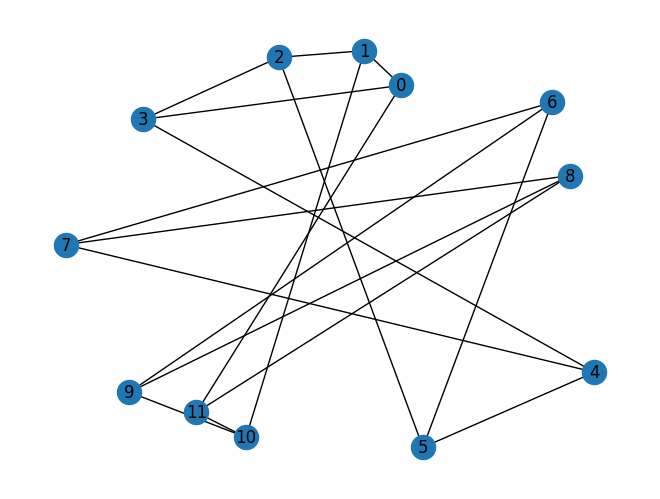

In [16]:
# SETUP: draw graph 1

draw(moo_graphs[1], with_labels=True)

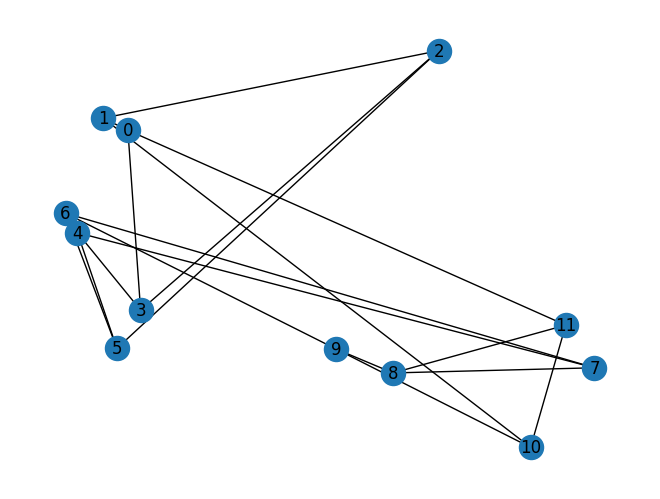

In [17]:
# SETUP: draw graph 2

draw(moo_graphs[2], with_labels=True)

In [18]:
from qiskit_addon_opt_mapper.applications import Maxcut
from qiskit_addon_opt_mapper.translators import to_ising

maxcuts = [Maxcut(g).to_optimization_problem() for g in moo_graphs]
print(maxcuts[0])
cost_ops = [to_ising(mc)[0].simplify() for mc in maxcuts]
print(cost_ops[0])

maximize 0.2516*x_0*x_1 - 0.2436*x_0*x_11 + 0.64*x_0*x_3 - 0.0214*x_1*x_10 - 1.4388*x_1*x_2 + 4.6312*x_10*x_11 + 4.1176*x_2*x_3 + 1.5778*x_2*x_5 + 0.1554*x_3*x_4 - 1.1186*x_4*x_5 - 3.5494*x_4*x_7 + 4.261*x_5*x_6 + 0.1412*x_6*x_7 + 0.6332*x_6*x_9 - 2.6218*x_7*x_8 + 0.2578*x_8*x_11 + 2.2112*x_8*x_9 - 2.8986*x_9*x_10 - 0.324*x_0 + 0.6043000000000001*x_1 - 0.8555999999999999*x_10 - 2.3226999999999998*x_11 - 2.1283000000000003*x_2 - 2.4565*x_3 + 2.2563*x_4 - 2.3601*x_5 - 2.5177000000000005*x_6 + 3.0149999999999997*x_7 + 0.07640000000000005*x_8 + 0.027100000000000124*x_9 (12 variables, 0 constraints, 'Max-cut')
SparsePauliOp(['IIIIIIIIIIZZ', 'IIIIIIIIZIIZ', 'ZIIIIIIIIIIZ', 'IIIIIIIIIZZI', 'IZIIIIIIIIZI', 'IIIIIIIIZZII', 'IIIIIIZIIZII', 'IIIIIIIZZIII', 'IIIIIIZZIIII', 'IIIIZIIZIIII', 'IIIIIZZIIIII', 'IIIIZZIIIIII', 'IIZIIZIIIIII', 'IIIZZIIIIIII', 'IIZZIIIIIIII', 'ZIIZIIIIIIII', 'IZZIIIIIIIII', 'ZZIIIIIIIIII'],
              coeffs=[-0.0629 +0.j, -0.16   +0.j,  0.0609 +0.j,  0.3597 +0.j,  0.00

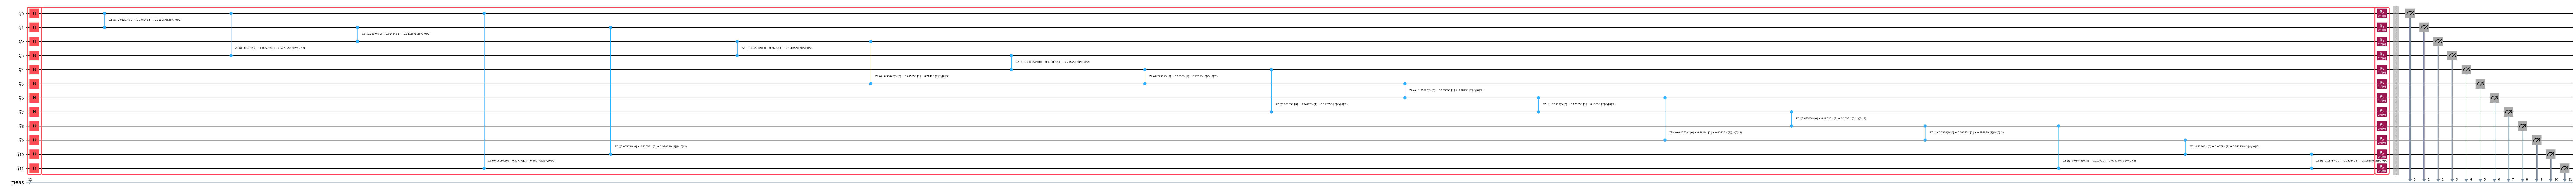

In [19]:
from qiskit.circuit import ParameterVector
from qopt_best_practices.circuit_library import annotated_qaoa_ansatz

c_vec = ParameterVector("c", len(cost_ops))
sum_cost_op = sum(c_vec[idx] * hc for idx, hc in enumerate(cost_ops)).simplify()
qc = annotated_qaoa_ansatz(sum_cost_op, reps=1)
qc.measure_all(inplace=True)
qc.draw("mpl", idle_wires=False, fold=-1)

In [20]:
print(sum_cost_op)

SparsePauliOp(['IIIIIIIIIIZZ', 'IIIIIIIIZIIZ', 'ZIIIIIIIIIIZ', 'IIIIIIIIIZZI', 'IZIIIIIIIIZI', 'IIIIIIIIZZII', 'IIIIIIZIIZII', 'IIIIIIIZZIII', 'IIIIIIZZIIII', 'IIIIZIIZIIII', 'IIIIIZZIIIII', 'IIIIZZIIIIII', 'IIZIIZIIIIII', 'IIIZZIIIIIII', 'IIZZIIIIIIII', 'ZIIZIIIIIIII', 'IZZIIIIIIIII', 'ZZIIIIIIIIII'],
              coeffs=[<qiskit._accelerate.circuit.ParameterExpression object at 0x116603f30>,
 <qiskit._accelerate.circuit.ParameterExpression object at 0x116603c90>])


In [21]:
print(sum_cost_op.coeffs[0])

(-0.0629)*c[0] + 0.1782*c[1] + 0.21305*c[2]


In [22]:
print(sum_cost_op.coeffs[1])

(-0.16)*c[0] - 0.0653*c[1] + 0.50735*c[2]


In [23]:
for coeff in sum_cost_op.coeffs:
    print(coeff)

(-0.0629)*c[0] + 0.1782*c[1] + 0.21305*c[2]
(-0.16)*c[0] - 0.0653*c[1] + 0.50735*c[2]
0.0609*c[0] - 0.9277*c[1] - 0.4007*c[2]
0.3597*c[0] + 0.0146*c[1] + 0.11155*c[2]
0.00535*c[0] - 0.92655*c[1] - 0.31065*c[2]
(-1.0294)*c[0] - 0.268*c[1] - 0.45845*c[2]
(-0.39445)*c[0] - 0.40555*c[1] - 0.7142*c[2]
(-0.03885)*c[0] - 0.31585*c[1] + 0.7859*c[2]
0.27965*c[0] - 0.6699*c[1] + 0.7706*c[2]
0.88735*c[0] - 0.24225*c[1] - 0.31295*c[2]
(-1.06525)*c[0] - 0.06935*c[1] + 0.2823*c[2]
(-0.0353)*c[0] - 0.17555*c[1] - 0.1739*c[2]
(-0.1583)*c[0] - 0.2619*c[1] + 0.33115*c[2]
0.65545*c[0] - 0.18025*c[1] + 0.1038*c[2]
(-0.5528)*c[0] - 0.60625*c[1] + 0.59585*c[2]
(-0.06445)*c[0] - 0.011*c[1] - 0.07805*c[2]
0.72465*c[0] - 0.0879*c[1] + 0.59175*c[2]
(-1.1578)*c[0] + 0.2328*c[1] + 0.19555*c[2]
